In [1]:
import requests
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [7]:
# AUTO DATE HANDLING
today = datetime.today()

# If before the 16th, use previous month
if today.day < 16:
    target_date = today - relativedelta(months=1)
else:
    target_date = today

release_month = target_date.month
release_year = target_date.year

release_date = f"{release_month}_{release_year}"
LAKE_CODE = "919"


URL = (
    f"https://www.usbr.gov/uc/water/hydrodata/crmms/current/"
    f"{release_date}/919/json/30.json"
)

EXCEL_PATH = "inflow_24_months_wide.xlsx"
SHEET_NAME = "Data"

print(f"Using release_date = {release_date}")
print(f"Fetching URL = {URL}")

# MAIN BLOCK WITH ERROR HANDLING

try:
    # 1. REQUEST + BUILD RAW DF
    r = requests.get(URL)          # <-assign to r
    r.raise_for_status()
    j = r.json()

    df_raw = pd.DataFrame(j["data"], columns=j["columns"])
    df_raw.insert(0, "timestamp", pd.to_datetime(j["index"], unit="ms"))

    # Keep only desired columns
    cols = ["timestamp", "24MS MOST PROB", "24MS MIN PROB", "24MS MAX PROB"]
    df = df_raw[cols].copy()

    # Sort by timestamp to ensure correct month order
    df = df.sort_values("timestamp").reset_index(drop=True)

    
    df = df.iloc[:24].copy()

    # ASSIGN MONTH NUMBER (1–24)
    df["month"] = df.index + 1   # month_1, month_2, ...

    # Melt to long to pivot into months
    df_long = df.melt(
        id_vars=["month"],
        value_vars=["24MS MOST PROB", "24MS MIN PROB", "24MS MAX PROB"],
        var_name="variable",
        value_name="value"
    )

    # Add release_date
    df_long["release_date"] = release_date

    # PIVOT TO WIDE FORMAT (release_date, variable, month_1..month_24)
    df_wide = df_long.pivot_table(
        index=["release_date", "variable"],
        columns="month",
        values="value"
    )

    # Clean up column names → month_1, month_2, …
    df_wide.columns = [f"month_{m}" for m in df_wide.columns]
    df_wide = df_wide.reset_index()

    print("\nPreview of wide-format (months 1–24):")
    print(df_wide.head().to_string(index=False))

    # APPEND TO HISTORY FILE (WITH ERROR HANDLING)
    if os.path.exists(EXCEL_PATH):
        try:
            df_old = pd.read_excel(EXCEL_PATH, sheet_name=SHEET_NAME)
            print(f"\nLoaded existing history with {len(df_old)} rows.")
        except PermissionError:
            print(f"Cannot access {EXCEL_PATH}. The file may be open in another program.")
            # Alternative: Save to a different file
            EXCEL_PATH = "inflow_30_months_wide_new.xlsx"
            print(f"Will save to {EXCEL_PATH} instead.")
            df_old = pd.DataFrame(columns=df_wide.columns)
        except Exception as e:
            print(f"Error reading file: {e}")
            df_old = pd.DataFrame(columns=df_wide.columns)
    else:
        df_old = pd.DataFrame(columns=df_wide.columns)

    # Combine old + new
    df_combined = pd.concat([df_old, df_wide], ignore_index=True)

    # Remove duplicates per release_date + variable
    df_combined = df_combined.drop_duplicates(
        subset=["release_date", "variable"],
        keep="last"
    )

    # Save with error handling
    try:
        df_combined.to_excel(EXCEL_PATH, sheet_name=SHEET_NAME, index=False)
        print(f"\nSaved updated monthly wide-format history → {EXCEL_PATH}\n")
    except PermissionError:
        alt_path = f"inflow_30_months_wide_{release_date}.xlsx"
        df_combined.to_excel(alt_path, sheet_name=SHEET_NAME, index=False)
        print(f"\nPermission denied on original file. Saved to → {alt_path}\n")

    # Also save to CSV
    csv_path = "inflow_24_months_wide.csv"
    try:
        df_combined.to_csv(csv_path, index=False)
        print(f"Saved CSV history → {csv_path}")
    except Exception as e:
        print(f"Could not save CSV: {e}")


except Exception as e:
    print(f"An error occurred: {e}")


Using release_date = 1_2026
Fetching URL = https://www.usbr.gov/uc/water/hydrodata/crmms/current/1_2026/919/json/30.json

Preview of wide-format (months 1–24):
release_date       variable    month_1    month_2    month_3    month_4    month_5     month_6     month_7    month_8    month_9   month_10   month_11   month_12   month_13   month_14   month_15   month_16   month_17   month_18   month_19    month_20   month_21   month_22   month_23   month_24
      1_2026  24MS MAX PROB 312811.019 301242.312 277937.603 392404.772 927320.419 1747813.210 2267162.670 964049.079 642273.784 591751.841 604635.950 512538.064 461076.836 483894.628 481472.554 627442.039 982884.415 2510755.19 2799887.15 1247327.370 611902.913 557428.927 559808.164 517982.962
      1_2026  24MS MIN PROB 312811.019 301242.312 277937.603 377133.946 353785.691  510928.198  710389.232 426094.498 363632.249 342353.070 395544.183 409070.208 351563.836 331325.628 365181.046 498353.944 604920.989 1284812.17 1256625.46  419730.995

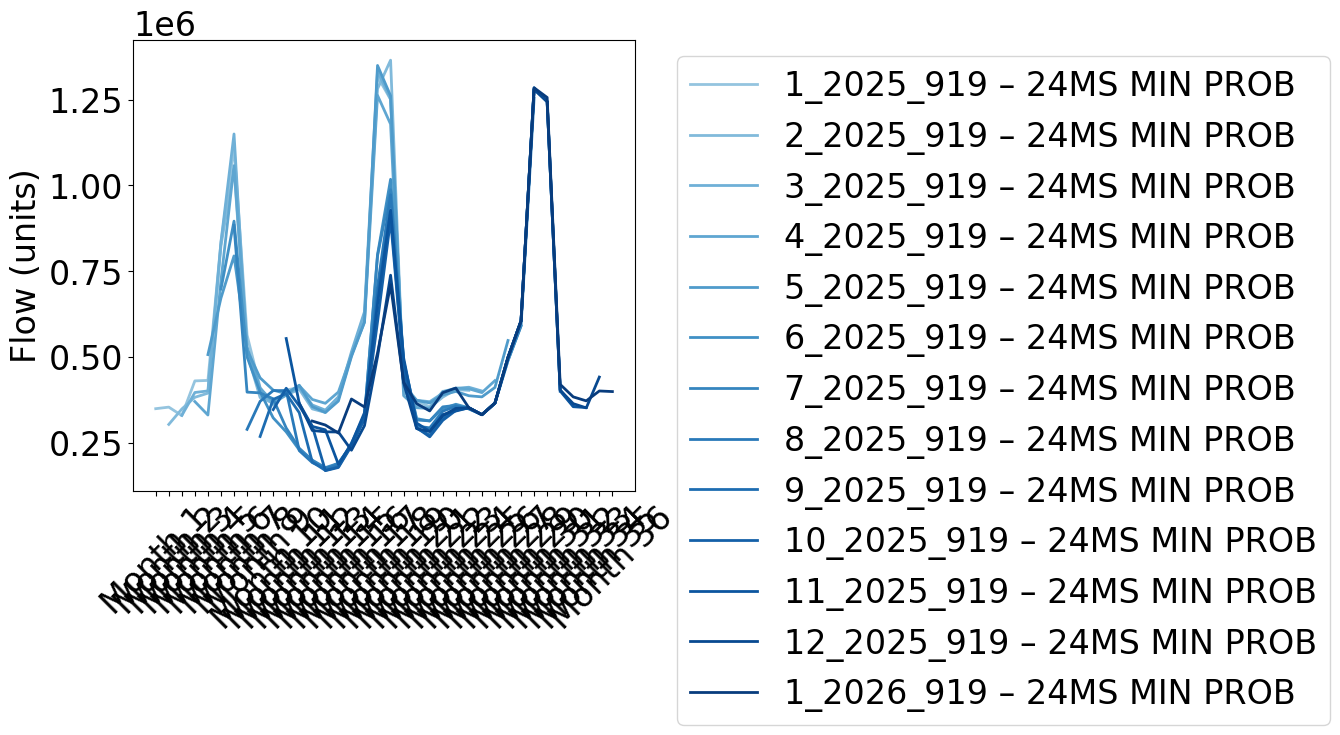

In [15]:
# Load the Excel sheet
df = pd.read_excel('inflow_24_months_wide.xlsx', sheet_name='Data')

# Drop empty columns
df = df.dropna(axis=1, how='all')

# Filter to only 24MS MIN PROB
df_min = df[df['variable'] == '24MS MIN PROB'].copy()

# Create a trace name
df_min['Trace'] = df_min['release_date'] + ' – ' + df_min['variable']
df_min = df_min.set_index('Trace')

# Month columns
months = [f'month_{i}' for i in range(1, 25)]

# Number of traces
n_traces = len(df_min)

# Extended x-axis length
total_months = 24 + (n_traces - 1)

# New labels
labels = [f'Month {i}' for i in range(1, total_months + 1)]

# Blue gradient
colors = plt.cm.Blues(np.linspace(0.4, 0.95, n_traces))

plt.figure(figsize=(14, 7))

for i, (trace, color) in enumerate(zip(df_min.index, colors)):
    y = df_min.loc[trace, months].values
    
    # Stagger by i months
    shifted = np.concatenate([np.full(i, np.nan), y])
    
    # Pad to full length
    if len(shifted) < total_months:
        shifted = np.concatenate([shifted, np.full(total_months - len(shifted), np.nan)])
    
    plt.plot(labels, shifted, label=trace, linewidth=2, color=color)

plt.ylabel('Flow (units)')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


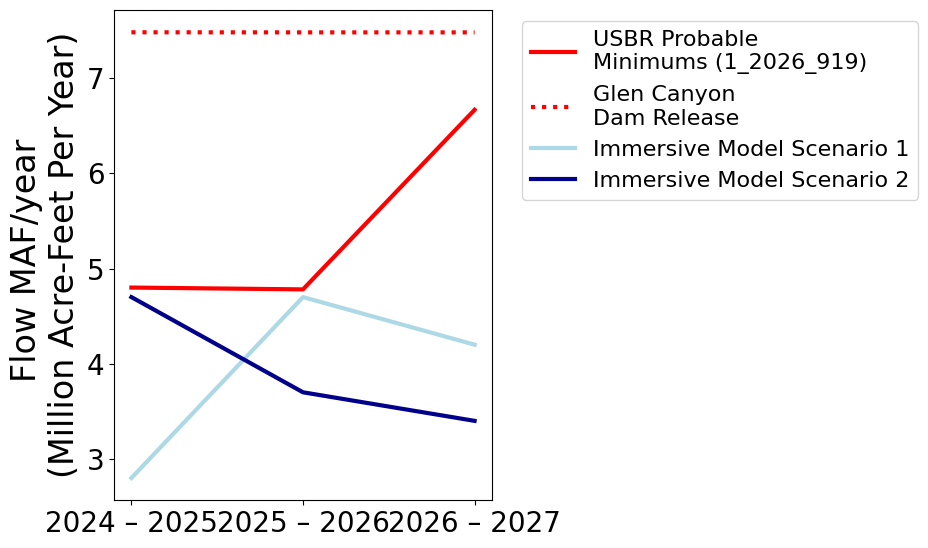

In [17]:
df = pd.read_excel('inflow_24_months_wide.xlsx', sheet_name='Data')
df = df.dropna(axis=1, how='all')

df_min = df[df['variable'] == '24MS MIN PROB'].copy()
df_min['Trace'] = df_min['release_date'] + ' – ' + df_min['variable']
df_min = df_min.set_index('Trace')

months = [f'month_{i}' for i in range(1, 25)]

# Convert monthly → annual totals
annual_df = pd.DataFrame()

for trace in df_min.index:
    monthly_vals = df_min.loc[trace, months].values.astype(float)

    Year_1 = 4.8
    Year_2 = (monthly_vals[:12].sum()/1000000)
    Year_3 = (monthly_vals[12:24].sum()/1000000)

    annual_df.loc[trace, 'Year_1'] = Year_1
    annual_df.loc[trace, 'Year_2'] = Year_2
    annual_df.loc[trace, 'Year_3'] = Year_3

# Identify most recent release
most_recent_trace = df_min.index[-1]
most_recent_release_date = df_min.loc[most_recent_trace, 'release_date']

# Rename for plotting
usbr_label = f"USBR Probable Minimums ({most_recent_release_date})"
annual_df = annual_df.rename(index={most_recent_trace: usbr_label})

# LOAD IMMERSIVE MODEL SHEET (same workbook, new sheet)

imm = pd.read_excel('inflow_24_months_wide.xlsx', sheet_name='ImmersiveModel')

# Expected format:
# Trace | Year_1 | Year_2 | Year_3 | Notes
imm = imm.set_index('Trace')

# Keep only Year_1–Year_3
imm = imm[['Year_1', 'Year_2', 'Year_3']]


#  MERGE USBR + IMMERSIVE MODEL


combined = pd.concat([annual_df, imm], axis=0)


#  PLOT

years = ['Year_1', 'Year_2', 'Year_3']
year_labels = ['Year 1', 'Year 2', 'Year 3']

custom_styles = {
    usbr_label: {'color': 'red', 'linestyle': '-', 'linewidth': 3},
    'Glen Canyon Dam Release': {'color': 'red', 'linestyle': ':', 'linewidth': 3},
    'Immersive Model Scenario 1': {'color': 'lightblue', 'linestyle': '-', 'linewidth': 3},
    'Immersive Model Scenario 2': {'color': 'darkblue', 'linestyle': '-', 'linewidth': 3},
}

plt.figure(figsize=(10, 6))

for trace, style in custom_styles.items():
    if trace in combined.index:
        wrapped_label = trace.replace('Glen Canyon Dam Release', 'Glen Canyon\nDam Release') \
                             .replace('USBR Probable Minimums', 'USBR Probable\nMinimums')
        plt.plot(year_labels, combined.loc[trace, years], label=wrapped_label, **style)

plt.ylabel('Flow MAF/year \n(Million Acre-Feet Per Year)')
plt.rcParams.update({'font.size': 24})
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)
plt.tight_layout()
plt.show()
